In [13]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt




# Sharpening using smooth filters




> We've seen that smooth filters are used to blur and remove info from the image.
<br>
In this part your task is to do the opposite ! Use them to actually make the image sharper



- hint: $$
g_{\text{sharp}} = f + \gamma \left( f - h_{\text{blur}} * f \right)
$$


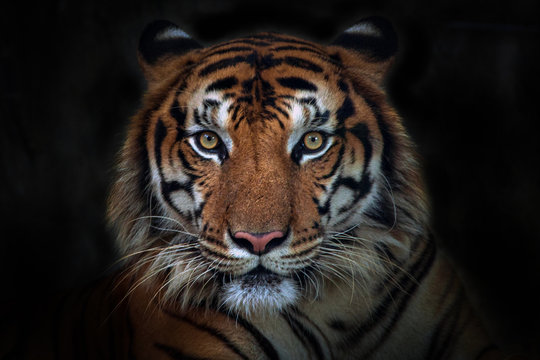

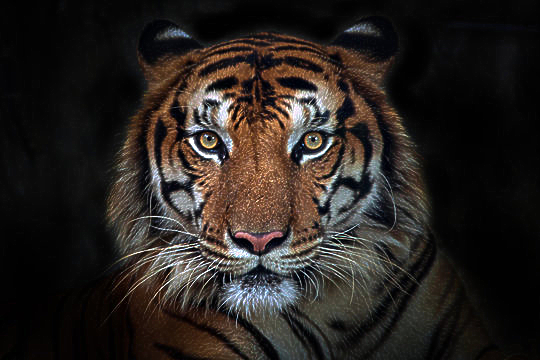

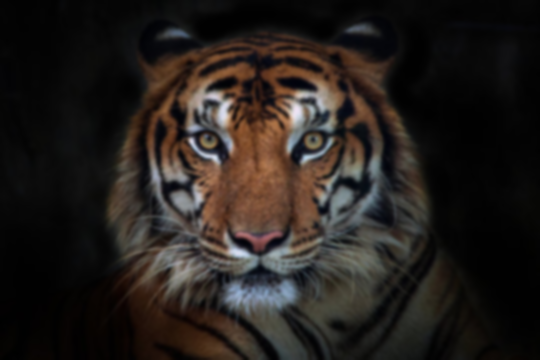

In [ ]:
def sharpen_image(image, kernel_size=(7, 7), gamma=2):
    # 1. Apply a smoothing filter (Gaussian blur)
    blur = cv2.GaussianBlur(image, kernel_size, 0)

    # 2. Calculate the difference between the original and blurred image
    detail = cv2.subtract(image, blur)

    # 3. Apply the gamma factor
    sharpened_detail = cv2.addWeighted(image, 1.0, detail, gamma, 0)

    # 4. Make sure output has the same type as original
    sharpened_detail = np.clip(sharpened_detail, 0, 255).astype(np.uint8)

    return sharpened_detail, blur

image = cv2.imread('tiger.jpg')
if image is not None:
    sharpened_img, blur = sharpen_image(image)

    cv2_imshow(image)
    cv2_imshow(sharpened_img)
    cv2_imshow(blur)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Could not load image.")


# Morphological Edge Detection

- Extract clean object boundaries by subtracting eroded image from its dilated version


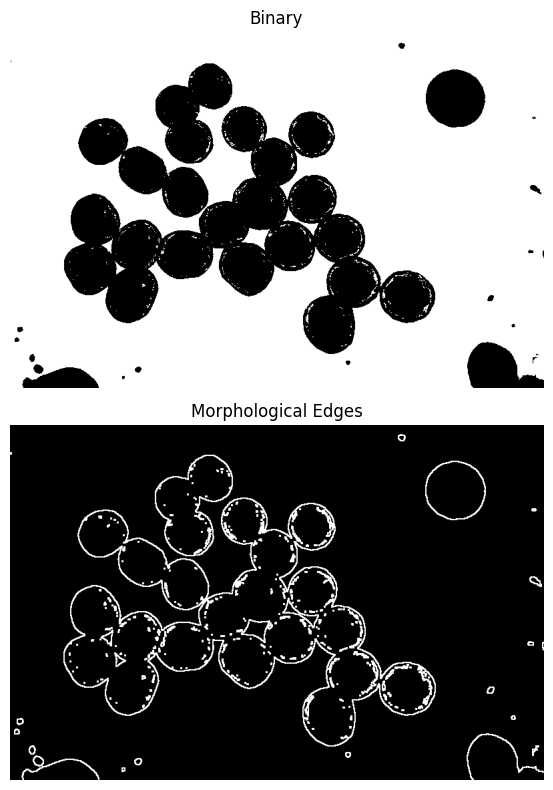

In [8]:

# Read the image
img = cv2.imread("bacteria.jpg", cv2.IMREAD_GRAYSCALE)

# Threshold to binary
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological Gradient (edges)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
edges = cv2.morphologyEx(binary, cv2.MORPH_GRADIENT, kernel)

# Show results (without axes)
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.imshow(binary, cmap='gray')
plt.title("Binary")
plt.axis("off")

plt.subplot(2,1,2)
plt.imshow(edges, cmap='gray')
plt.title("Morphological Edges")
plt.axis("off")

plt.tight_layout()
plt.show()


# Count bacteria



> Add blockquote



bonus:
- find a way to calculate the kernel size automatically (based on overlaps or cell sizes for example)
- reconstruct cells by dilation after counting them

Number of bacteria detected: 26


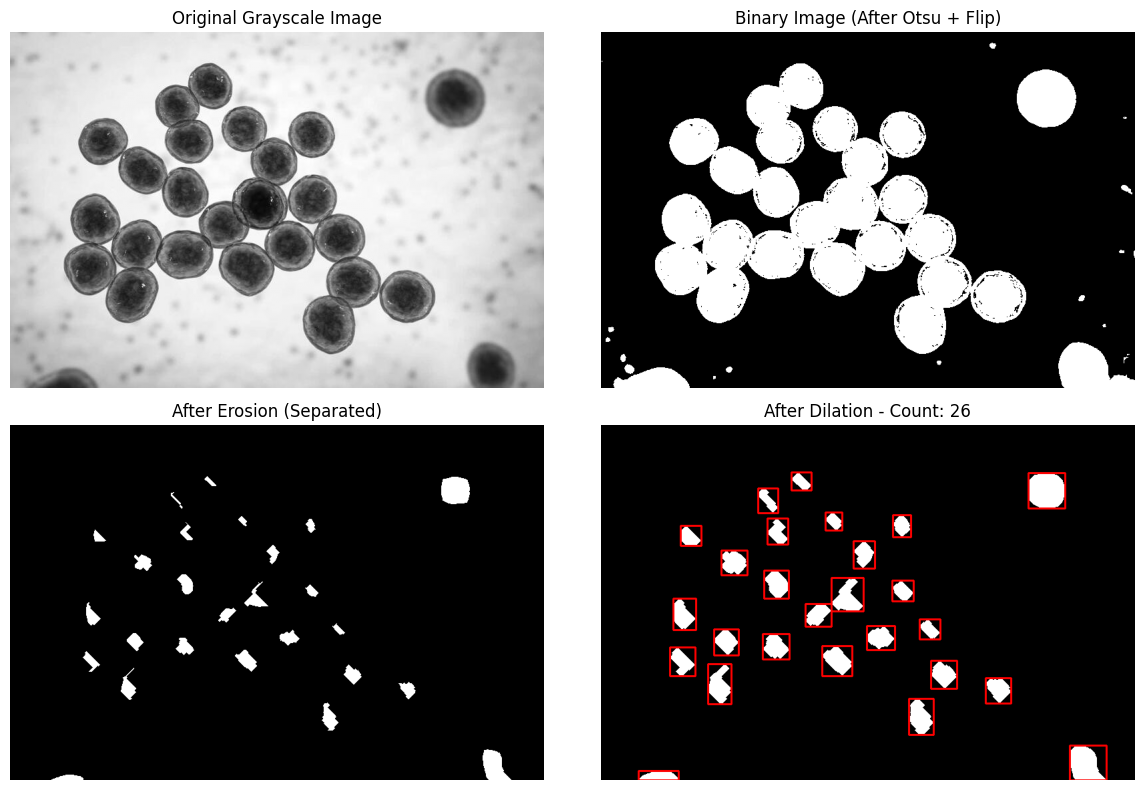

In [12]:
# Load image
img = cv2.imread("bacteria.jpg", cv2.IMREAD_GRAYSCALE)

# Display original image
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

# Otsu thresholding
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Flip the colors (for morphology operations - bacteria should be white)
binary = cv2.bitwise_not(binary)

plt.subplot(2, 2, 2)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image (After Otsu + Flip)')
plt.axis('off')

# Create kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Erosion to separate bacteria (apply many iterations to fully separate)
eroded = binary.copy()

# I applied erosion 23 times to completely separate the bacteria from each other
# but I'm not sure if this approach is correct or not
for i in range(23):
    eroded = cv2.erode(eroded, kernel, iterations=1)

plt.subplot(2, 2, 3)
plt.imshow(eroded, cmap='gray')
plt.title('After Erosion (Separated)')
plt.axis('off')

# Connected component analysis to count bacteria
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded, connectivity=8)
valid_bacteria = []
bacteria_count = num_labels-1

for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    valid_bacteria.append(i)

print(f"Number of bacteria detected: {bacteria_count}")

# Dilation to restore bacteria size (but keep them separated)
# Use the original binary image centers but dilate them back to reasonable size
dilated = eroded.copy()
for i in range(6):  # More dilation to restore size but keep separated
    dilated = cv2.dilate(dilated, kernel, iterations=1)

# Create the dilated image with bounding boxes
dilated_with_boxes = cv2.cvtColor(dilated, cv2.COLOR_GRAY2BGR)

# Draw bounding boxes on the dilated image
for label_id in valid_bacteria:
    # Get bounding box coordinates from the eroded image stats
    x = stats[label_id, cv2.CC_STAT_LEFT]
    y = stats[label_id, cv2.CC_STAT_TOP]
    w = stats[label_id, cv2.CC_STAT_WIDTH]
    h = stats[label_id, cv2.CC_STAT_HEIGHT]

    # Expand the bounding box to account for dilation
    expansion = 6  # Same as dilation iterations
    x = max(0, x - expansion)
    y = max(0, y - expansion)
    w = min(dilated.shape[1] - x, w + 2 * expansion)
    h = min(dilated.shape[0] - y, h + 2 * expansion)

    # Draw red rectangle
    cv2.rectangle(dilated_with_boxes, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(dilated_with_boxes, cv2.COLOR_BGR2RGB))
plt.title(f'After Dilation - Count: {bacteria_count}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional



> Learn as much as you want about CNNs and ask mentors (CNNs will be taught in future sessions)



# Sources:
- Computer Vision: Algorithms and Applications
- Dr. Karimi videos
- Google
- My own knowledge